In [2]:
import stim
import numpy as np
import galois
import qrm

In [37]:
def to_matrix_np(L):
    F = galois.GF(2)
    M = np.zeros((10, 15), dtype=np.uint8)
    for i, cols in enumerate(L):
        if len(cols) == 0:
            continue
        cols = list(filter(lambda x: x != 0, cols))
        idx = np.asarray(cols) - 1  # convert 1-based to 0-based
        M[i, idx] = 1
    M = M.view(F)
    return M

sub_col = [i - 1 for i in [1,2,4,8,3,5,6,9,10,12]]  # select 10 columns from 15 columns
H = to_matrix_np(qrm.QRM_Z_CHECKS[:10])[:, sub_col]
# print(M)
C = np.linalg.inv(H)
N = H @ C
print(f' N: {N}')
print(C)
# I = np.eye(10, dtype=np.uint8).view()
# C = []
# for i in range(10):
#     b = np.zeros(10, dtype=np.uint8)
#     b[i] = 1
#     s = (M, b)
#     C.append(s)
# C = np.array(C, dtype=np.uint8).transpose()
C

 N: [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
[[1 1 1 0 0 0 0 0 1 1]
 [0 0 1 1 1 0 0 0 1 1]
 [0 0 0 0 1 1 1 0 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [0 1 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 1 0]
 [1 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 1 0 0 1]]


GF([[1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 1]], order=2)

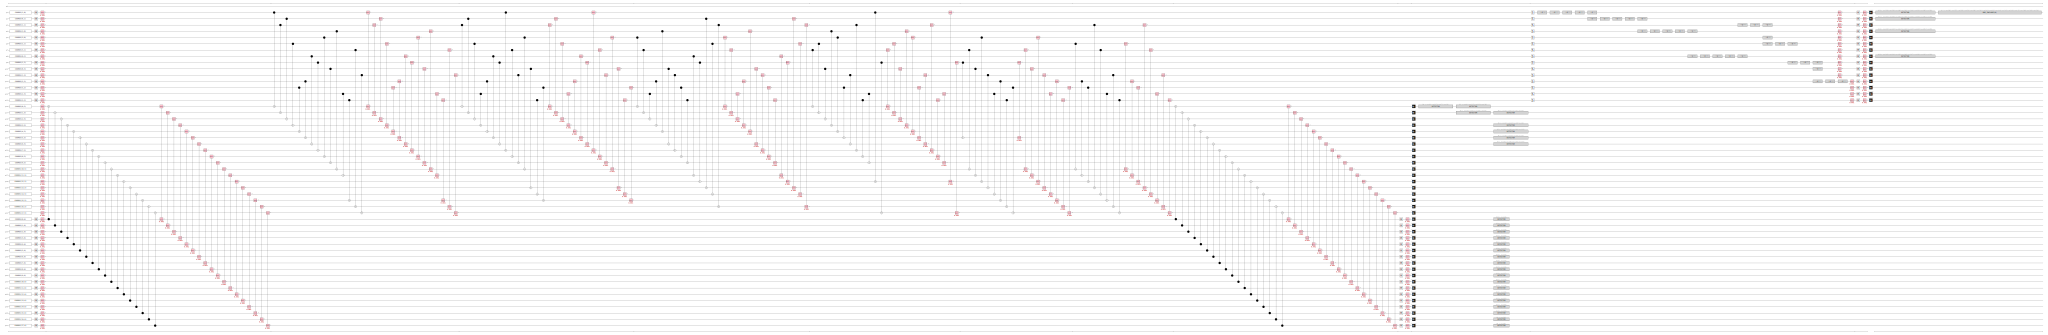

In [29]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [qrm.get_bit(i,0) + 2 * qrm.get_bit(i,2), qrm.get_bit(i,1) + 2 * qrm.get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = qrm.QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for mc in qrm.QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # apply transversal gates
    circuit.append('S', list(range(1, 16)))
    for i in range(10):
        for j in range(10):
            if C[i, j] == 1:
                #conditioned Z gate
                circuit.append('CZ', [stim.target_rec(j - 36), sub_col[i] + 1])
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for stabilizer in qrm.QRM_X_CHECKS:
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

# Test the correctness of feedback algorithm

We rotate the code to standard and apply transversal $S$.

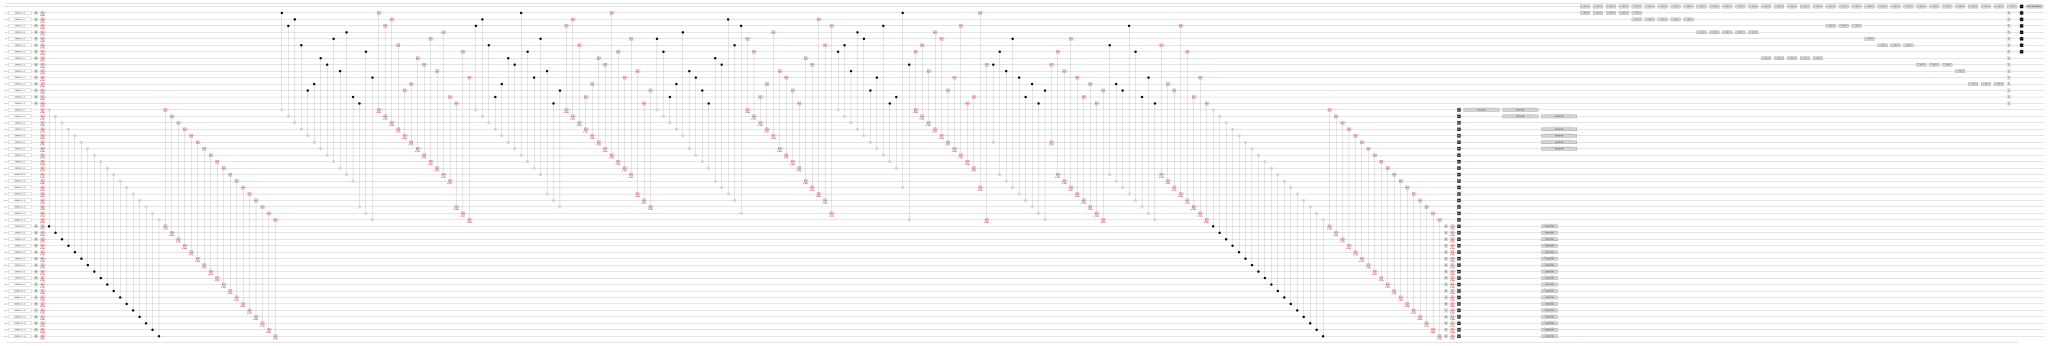

In [45]:
def qrm_circuit_flag(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [qrm.get_bit(i,0) + 2 * qrm.get_bit(i,2), qrm.get_bit(i,1) + 2 * qrm.get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = qrm.QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for mc in qrm.QRM_META_CHECKS:
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)]) 
    circuit.append('TICK')

    # apply transversal gates and introduct an ancilla qubit to record the parity
    for i in range(10):
        for j in range(10):
            if C[i, j] == 1:
                #conditioned Z gate
                circuit.append('CX', [stim.target_rec(j - 36), sub_col[i] + 1])
                circuit.append('CX', [stim.target_rec(j - 36), 0])
    circuit.append('S', list(range(1, 16)))
    # circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    logical_Y = [stim.target_z(0)]
    Y_list = [1, 2, 3]
    X_list = [4, 5, 6, 7]
    logical_Y.extend([stim.target_y(i) for i in Y_list])
    logical_Y.extend([stim.target_x(i) for i in X_list])
    logical_Y = stim.target_combined_paulis(logical_Y)
    circuit.append('MPP', logical_Y)
    circuit.append('TICK')
    
    # readout checks
    # for stabilizer in QRM_X_CHECKS:
    #     circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer])
    
    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', stim.target_rec(-1), 0)

    return circuit

circuit = qrm_circuit_flag(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')


In [46]:
circuit.diagram('matchgraph-svg')

ValueError: The circuit contains non-deterministic observables.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['L0', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:5 --filter_coords L0 > output_image.svg

This was discovered while analyzing qubit initialization into |0> at the start of the circuit on:
    qubit 1 [coords (1, 0)]

The collapse anti-commuted with these detectors/observables:
    L0

The backward-propagating error sensitivity for L0 was:
    Z0
    Y1 [coords (1, 0)]
    Y2 [coords (0, 1)]
    Y3 [coords (1, 1)]
    Y4 [coords (2, 0)]
    Y5 [coords (3, 0)]
    Y6 [coords (2, 1)]
    Z7 [coords (3, 1)]
    X8 [coords (0, 2)]
    X9 [coords (1, 2)]
    X10 [coords (0, 3)]
    X12 [coords (2, 2)]
    Z16 [coords (0, 5)]
    Z18 [coords (2, 5)]
    Z19 [coords (3, 5)]
    Z20 [coords (4, 5)]
    Z21 [coords (5, 5)]

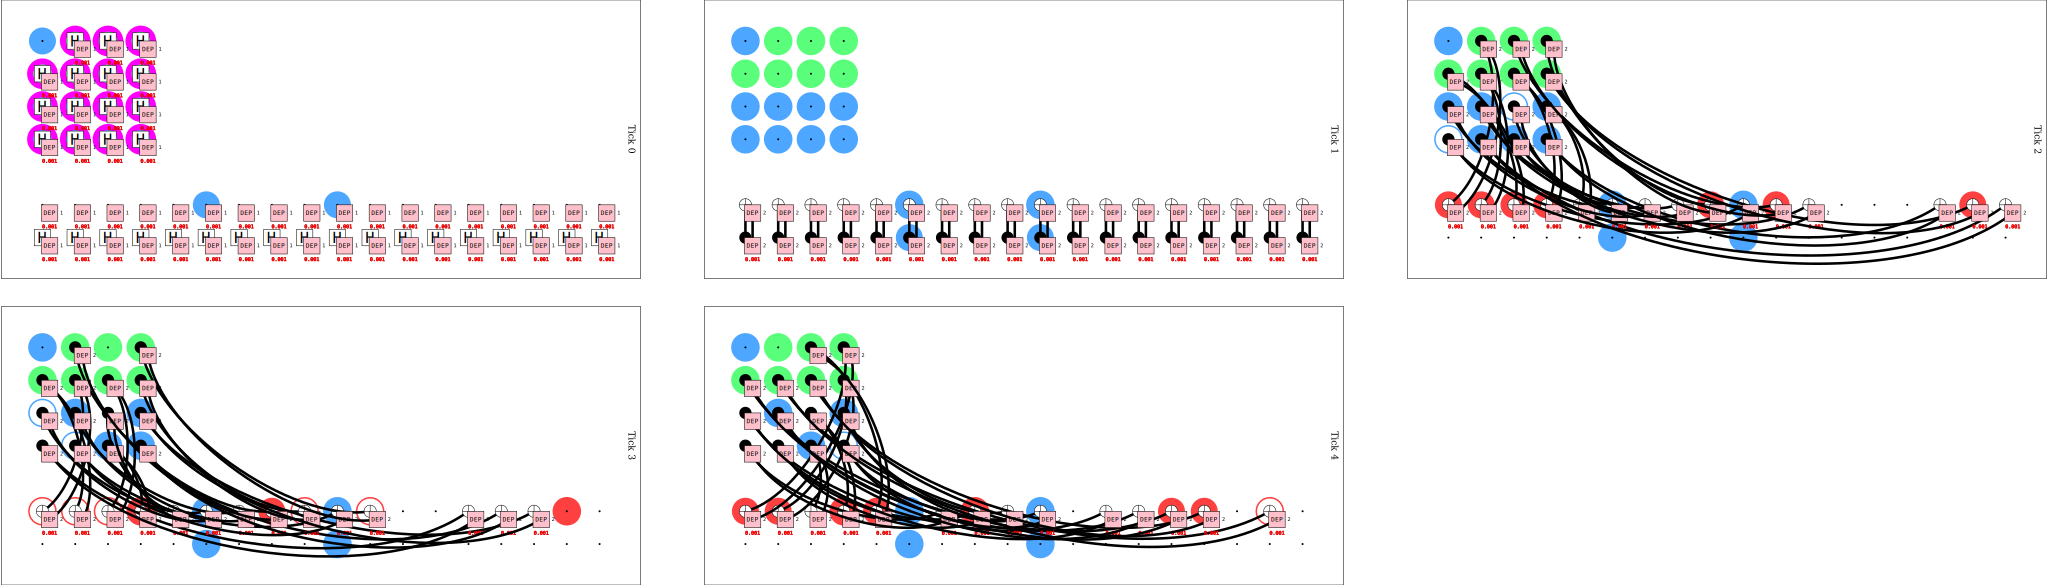

In [38]:
circuit.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['L0', ])